In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import arviz as az
import warnings
warnings.warn('ignore')

/home/anders/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/tmp/ipykernel_13374/690037048.py:12: UserWarning: ignore
  warnings.warn('ignore')


In [18]:
def target_func(x):
  return torch.sin(20*x) + 2*torch.cos(14*x) - 2*torch.sin(6*x)

X = torch.tensor([-1, -1/2, 0, 1/2, 1])

y = target_func(X)

In [61]:
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
kernel.variance = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
kernel.lengthscale = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
gpmodel = gp.models.GPRegression(X, y, kernel=kernel, noise = torch.tensor(1e-4))

hmc_kernel = pyro.infer.NUTS(gpmodel.model)

mcmc = pyro.infer.MCMC(hmc_kernel, num_samples=3000, warmup_steps = 1000)
    
mcmc.run()


Sample: 100%|██████████| 4000/4000 [01:54, 34.96it/s, step size=4.19e-01, acc. prob=0.720]


/usr/local/lib/python3.10/dist-packages/torch/distributions/distribution.py:166: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


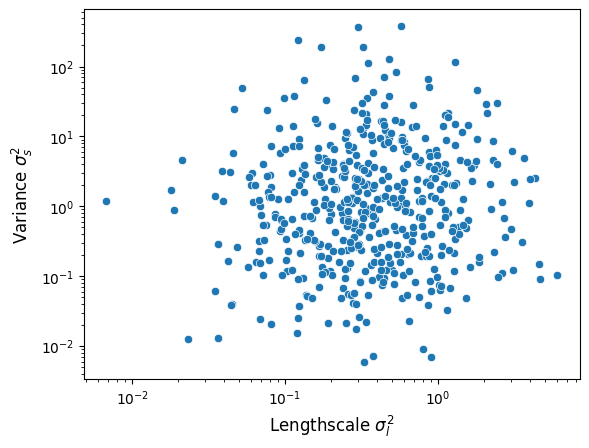

In [26]:
lengthprior = torch.distributions.LogNormal(-1, 1)
varianceprior = torch.distributions.LogNormal(0, 2)
x1 = lengthprior.sample_n(500)
y1 = varianceprior.sample_n(500)

f, ax = plt.subplots()
ax.set(xscale="log", yscale="log")
sns.scatterplot(x = x1, y = y1)
ax.set_xlabel("Lengthscale $\sigma_l^2$", fontsize = 12)
ax.set_ylabel("Variance $\sigma_s^2$", fontsize = 12)
plt.show()



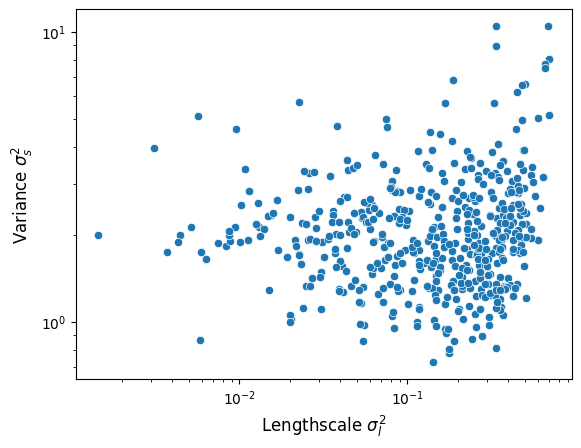

In [28]:
hyperparam = mcmc.get_samples()
x1 = hyperparam["kernel.lengthscale"][0:499]
y1 = hyperparam["kernel.variance"][0:499]

f, ax = plt.subplots()
ax.set(xscale="log", yscale="log")
sns.scatterplot(x = x1, y = y1)
ax.set_xlabel("Lengthscale $\sigma_l^2$", fontsize = 12)
ax.set_ylabel("Variance $\sigma_s^2$", fontsize = 12)
plt.show()

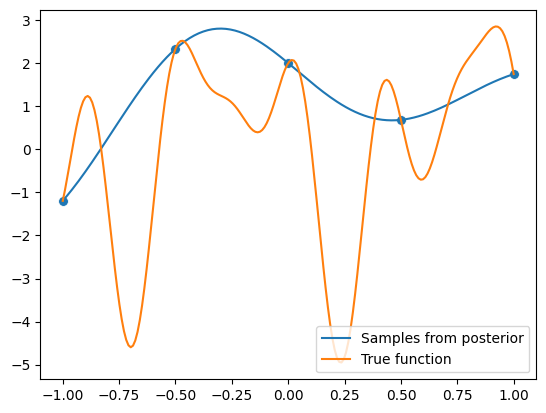

In [62]:
with torch.no_grad():
    x_new = torch.linspace(-1, 1, 200)
    mean_new = gpmodel.forward(x_new)[0] # Returns the mean of our posterior samples
    sd_new = gpmodel.forward(x_new)[1] # Returns the standard deviation of our posteriour samples
    f, ax = plt.subplots(1)
    sns.lineplot(x = x_new, y = mean_new, ax=ax, label = "Samples from posterior")
    sns.scatterplot(x = X, y = y, ax=ax, s = 50)
    ax.fill_between(x_new, mean_new+2*sd_new, mean_new-2*sd_new, facecolor='blue', alpha=0.4)
    sns.lineplot(x = x_new, y = target_func(x_new), ax = ax, label =  "True function")
    ax.legend(loc='lower right')
    plt.show()
    

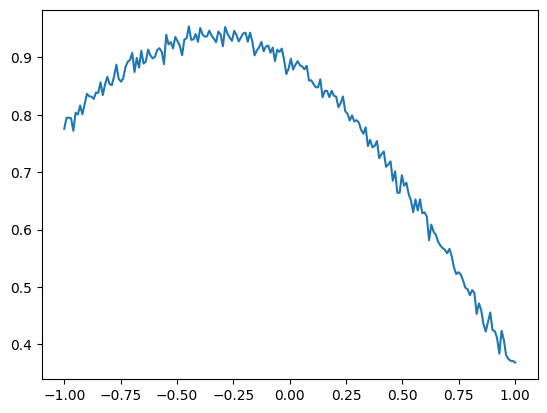

In [36]:
# plot prior
covprior = kernel.forward(x_new) + torch.tensor(1e-4).expand(x_new.shape[0]).diag()

yprior = dist.MultivariateNormal(
            torch.zeros(x_new.shape[0]), covariance_matrix=covprior
        ).sample(sample_shape=(1,))

sns.lineplot(x = x_new, y = yprior[0])
plt.show()


/home/anders/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


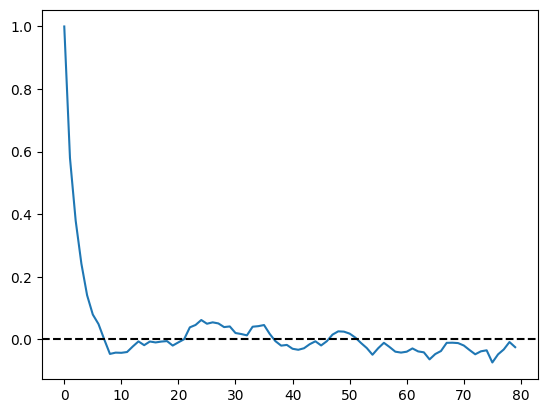

In [58]:
diag = az.from_pyro(mcmc, log_likelihood = False)
samples0 = mcmc.get_samples()
#az.plot_autocorr(diag)
#autocorr1 = az.autocorr(samples0["kernel.lengthscale"])
autocorr2 = az.autocorr(samples0["kernel.variance"])
xs = torch.arange(0, autocorr2.shape[0], 1)
sns.lineplot(x = xs[xs<80], y = autocorr2[xs<80])
plt.axhline(y = 0, color = "black", linestyle='dashed')
plt.show()

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


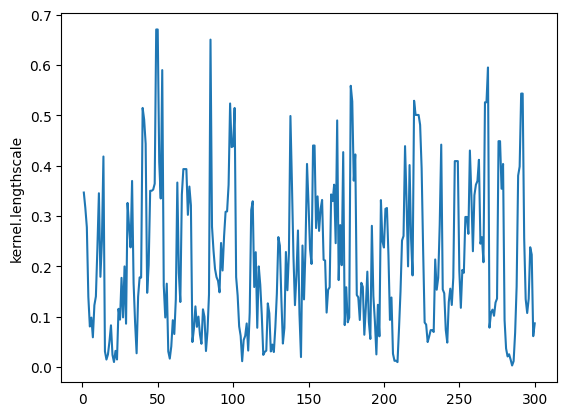

In [57]:
sum1 = az.summary(diag)
params =  az.extract(diag)

samples_kernel_lengthscale = params["kernel.lengthscale"]
samples_kernel_variance = params["kernel.variance"]

xs = np.arange(1, samples_kernel_variance.shape[0]+1, 1)

f, ax = plt.subplots()

#sns.lineplot(x = xs, y = samples_kernel_lengthscale, ax = ax)
sns.lineplot(x = xs[0:300], y = samples_kernel_lengthscale[0:300], ax = ax)
plt.show()



In [ ]:
warmup_array = np.array([10, 25, 50, 100, 150, 300, 400, 500])
diag_array = np.empty([warmup_array.size, 6])
mean_calc_arrary = np.empty([4,6])


for i in range(warmup_array.size):
    print(str(i) + ": Start")
    for j in range(4):
        pyro.clear_param_store()
        kernel = gp.kernels.RBF(input_dim=1)
        kernel.variance = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))
        kernel.lengthscale = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))
        gpmodel = gp.models.GPRegression(X, y, kernel=kernel, noise = torch.tensor(1e-4))

        hmc_kernel = pyro.infer.NUTS(gpmodel.model)

        mcmc = pyro.infer.MCMC(hmc_kernel, num_samples=500, warmup_steps = warmup_array[i])
        mcmc.run()
        print(str(i) + ": past MCMC")
        
        diag = az.from_pyro(mcmc)
        params =  az.extract(diag)
        print(str(i) + ": past arviz")
        sum2 = az.summary(diag)
        mean_calc_arrary[j][0] = sum2["ess_bulk"][0]/500
        mean_calc_arrary[j][1] = sum2["ess_bulk"][1]/500
        mean_calc_arrary[j][2] = sum2["ess_tail"][0]/500
        mean_calc_arrary[j][3] = sum2["ess_tail"][1]/500
        mean_calc_arrary[j][4] = sum2["mcse_mean"][0]
        mean_calc_arrary[j][5] = sum2["mcse_mean"][1]

    temp_array = np.median(mean_calc_arrary, axis = 0)
    
    diag_array[i][0] = temp_array[0]
    diag_array[i][1] = temp_array[1]
    diag_array[i][2] = temp_array[2]
    diag_array[i][3] = temp_array[3]
    diag_array[i][4] = temp_array[4]
    diag_array[i][5] = temp_array[5]


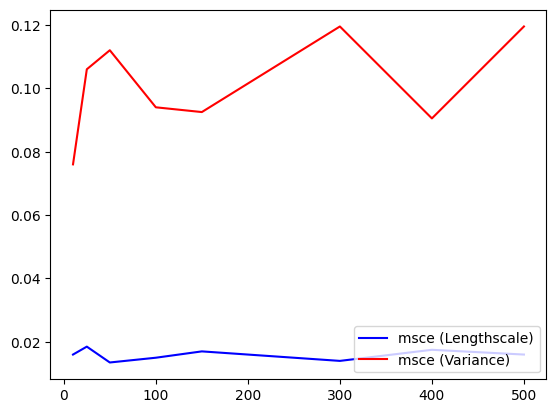

In [32]:
"""sns.lineplot(x = warmup_array, y = diag_array[:, 0])
sns.lineplot(x = warmup_array, y = diag_array[:, 1])
sns.lineplot(x = warmup_array, y = diag_array[:, 2])
sns.lineplot(x = warmup_array, y = diag_array[:, 3])
"""
f, ax = plt.subplots(1, 1)

#ax.plot(warmup_array, diag_array[:, 0], color="blue", label="Length_scale (ess_bulk)", linestyle="-")
#ax.plot(warmup_array, diag_array[:, 1], color="red", label="Variance (ess_bulk)", linestyle="-")
#ax.plot(warmup_array, diag_array[:, 2], color="green", label="Length_scale (ess_tail)", linestyle="-")
#ax.plot(warmup_array, diag_array[:, 3], color="yellow", label="Variance (ess_tail)", linestyle="-")
ax.plot(warmup_array, diag_array[:, 4], color="blue", label="msce (Lengthscale)", linestyle="-")
ax.plot(warmup_array, diag_array[:, 5], color="red", label="msce (Variance)", linestyle="-")
ax.legend(loc='lower right')

plt.show()



# PART 2

In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import arviz as az
import warnings
warnings.filterwarnings('ignore')

/home/anders/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [30]:
def target_func(x):
  return torch.sin(20*x) + 2*torch.cos(14*x) - 2*torch.sin(6*x)

X = torch.tensor([-1, -1/2, 0, 1/2, 1])

y = target_func(X)

In [25]:
x_test = torch.linspace(-1, 1, 200)
#torch.manual_seed(500) #finder min
# torch.manual_seed(18) finder min clutch
#torch.manual_seed(102)

0


Sample: 100%|██████████| 700/700 [00:21, 33.22it/s, step size=6.84e-01, acc. prob=0.818]


Try again


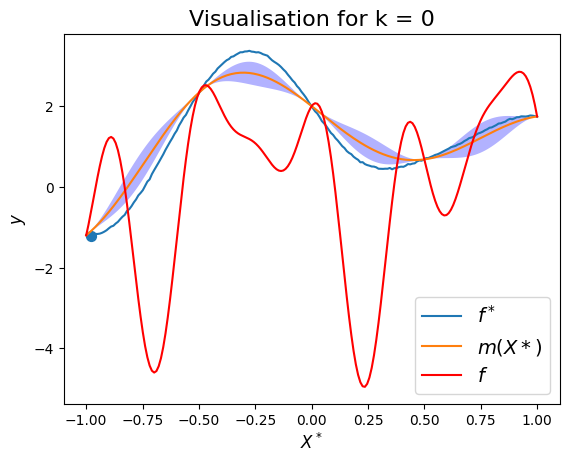

1


Sample: 100%|██████████| 700/700 [00:19, 36.06it/s, step size=7.74e-01, acc. prob=0.887]


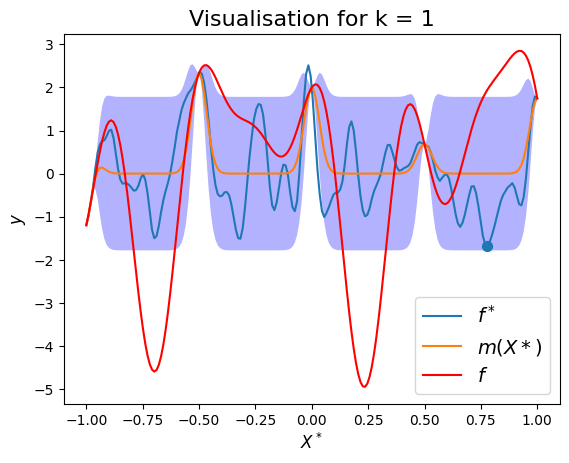

2


Sample: 100%|██████████| 700/700 [00:18, 37.39it/s, step size=7.45e-01, acc. prob=0.848]


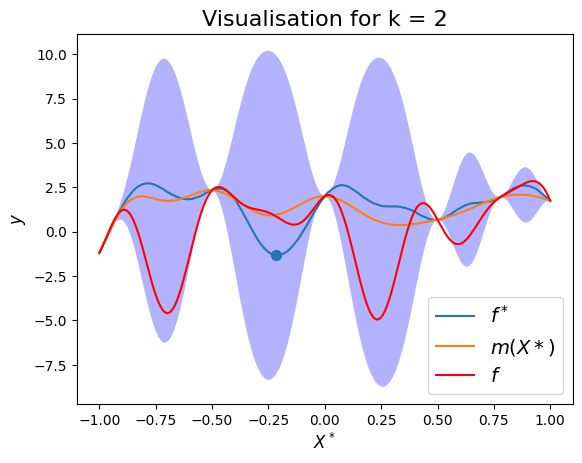

3


Sample:  93%|█████████▎| 653/700 [00:23, 33.46it/s, step size=4.57e-01, acc. prob=0.927]

In [31]:
for i in range(5):
    print(i)
    pyro.clear_param_store()
    kernel = gp.kernels.RBF(input_dim=1)
    kernel.variance = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(-1.0), torch.tensor(1.0)))

    kernel.lengthscale = pyro.nn.PyroSample(pyro.distributions.LogNormal(torch.tensor(0.0), torch.tensor(2.0)))

    gpmodel = gp.models.GPRegression(X, y, kernel=kernel, noise = torch.tensor(1e-4))

    noise = torch.tensor(1e-4)

    hmc_kernel = pyro.infer.NUTS(gpmodel.model)

    mcmc = pyro.infer.MCMC(hmc_kernel, num_samples=500, warmup_steps = 200)
    mcmc.run()

    hyperparam = mcmc.get_samples()
    x1 = hyperparam["kernel.lengthscale"]
    y1 = hyperparam["kernel.variance"]

    while(True):
        try:
            idx = torch.randint(0, 100, (1,))

            gpmodel.kernel.variance = y1[idx]

            gpmodel.kernel.lengthscale = x1[idx]

            loc, cov = gpmodel.forward(x_test, full_cov= True)

            cov = cov + noise.expand(x_test.shape[0]).diag()
        
        
            samples = dist.MultivariateNormal(loc, covariance_matrix=cov, validate_args = False).sample(sample_shape=(1,))
            min_value, min_idx = torch.min(samples[0], dim = 0, keepdim=False)
            xstar = x_test[min_idx.item()].reshape(1)
            if not (xstar in X):
                break
        except:
            print("Try again")

    mean_new = gpmodel.forward(x_test)[0] # Returns the mean of our posterior samples
    sd_new = gpmodel.forward(x_test)[1] # Returns the standard deviation of our posteriour samples
    fstar = target_func(xstar)

    X = torch.cat((X, xstar), 0)
    y = torch.cat((y, fstar), 0)
    
    with torch.no_grad():
        f, ax = plt.subplots(1)
        sns.lineplot(x = x_test, y = samples[0], label = "$f^*$", ax = ax)

        sns.lineplot(x = x_test, y = mean_new, ax=ax, label = "$m(X*)$")
        ax.fill_between(x_test, mean_new+2*sd_new, mean_new-2*sd_new, facecolor='blue', alpha=0.3)

        ax.scatter(xstar, min_value, marker='o', s=50)
        sns.lineplot(x = x_test, y = target_func(x_test), label = "$f$", ax = ax, color = "red")
        ax.legend(loc = "lower right", fontsize = 14)
        ax.set_title("Visualisation for k = "+ str(i), fontsize = 16)
        ax.set_xlabel("$X^*$", fontsize = 12, fontweight="bold")
        ax.set_ylabel("$y$", fontsize = 12, fontweight="bold")
        plt.show()

In [27]:
ymin, idxmin = torch.min(y, dim = 0, keepdim=False)
argmin = X[idxmin]
print(argmin)

tensor(0.2362)


In [29]:
#argmin_array = np.empty(10)
argmin_array

array([ 0.23618092,  0.23618092,  0.23618092,  0.5       ,  1.        ,
        2.        ,  2.5       ,  5.        , 10.        , 20.        ])

In [28]:
argmin_array[3] = argmin